In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_erosion 

In [6]:
image = cv2.imread("/mnt/e/Term 4/HW/DIP-HW8/data/images/q4/cells.png", cv2.IMREAD_GRAYSCALE)

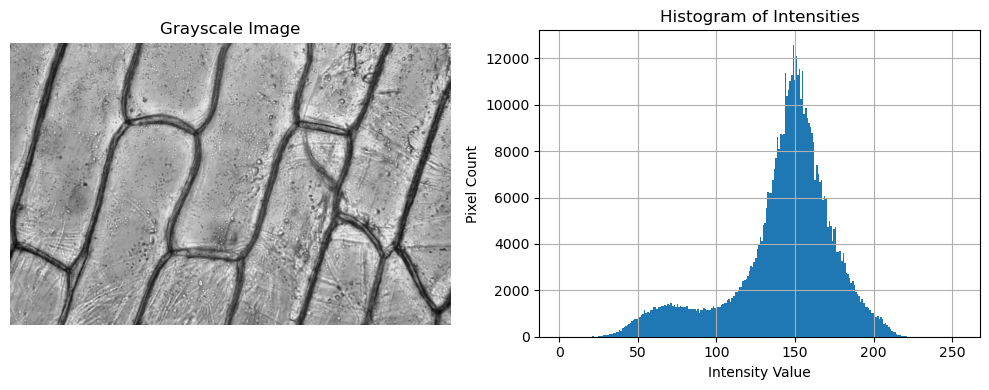

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Histogram of Intensities")
plt.hist(image.ravel(), bins=256, range=(0,255))
plt.xlabel('Intensity Value')
plt.ylabel('Pixel Count')
plt.grid(True)
plt.tight_layout()
plt.show()

(-0.5, 949.5, 607.5, -0.5)

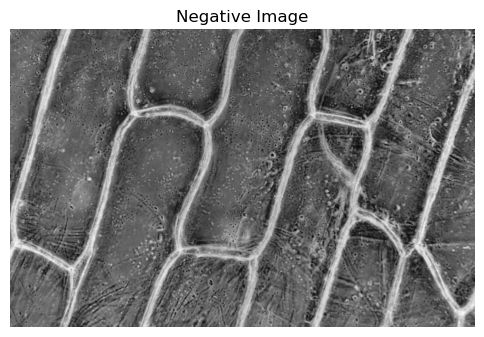

In [11]:
negative_image = 255 - image

plt.figure(figsize=(6, 6))
plt.title("Negative Image")
plt.imshow(negative_image, cmap='gray')
plt.axis('off')

In [12]:
image.shape

(608, 950)

In [39]:
h, w = image.shape

seed = (210, 130)
queue = [seed]

neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),
            (-1, -1), (-1, 1), (1, -1), (1, 1)]

threshold = 5

segmented = np.zeros_like(image, dtype=np.uint8)
visited = np.zeros_like(image, dtype=bool)

region_mean = int(image[seed])
visited[seed] = True
segmented[seed] = 255

while queue:
    x, y = queue.pop(0)

    for dx, dy in neighbors:
        nx, ny = x + dx, y + dy

        if nx >=0 and ny >= 0 and nx < h and ny < w and not visited[nx, ny]:
            if abs(int(image[nx, ny] - region_mean) <= threshold):
                segmented[nx, ny] = 255
                visited[nx, ny] = True
                queue.append((nx, ny))


(-0.5, 949.5, 607.5, -0.5)

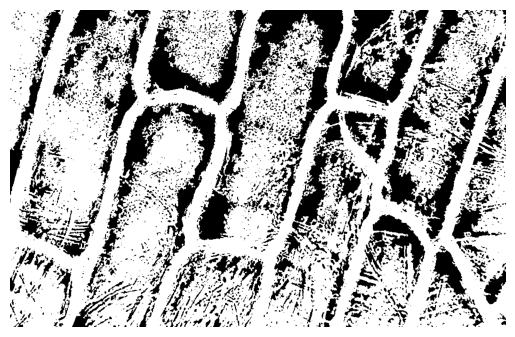

In [42]:
plt.imshow(segmented, cmap='grey')
plt.axis('off')

In [69]:
def region_growing(image, seeds, threshold):
    """
    Region Growing Segmentation
    ----------------------------
    image:     grayscale input image
    seeds:     list of (row, col) seed points
    threshold: intensity similarity threshold
    """
    
    # Get image dimensions
    h, w = image.shape
    
    # Output image: each region gets a unique label (1, 2, 3, ...)
    segmented = np.zeros((h, w), dtype=np.uint8)
    
    # Keep track of visited pixels (True = already processed)
    visited = np.zeros((h, w), dtype=bool)
    
    # Define 8-connected neighbors
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),
                 (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    # Process each seed separately
    for region_id, seed in enumerate(seeds, start=1):
        queue = [seed]                       # BFS queue starts with seed
        region_mean = int(image[seed])       # initial region intensity
        
        segmented[seed] = region_id          # mark seed in segmented image
        visited[seed] = True                 # mark seed as visited
        
        # Breadth-First Search (BFS)
        while queue:
            x, y = queue.pop(0)              # get first pixel from queue
            
            # Check all 8 neighbors
            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy
                
                # Check if within bounds and not visited
                if 0 <= nx < h and 0 <= ny < w and not visited[nx, ny]:
                    # Similarity check: intensity difference ≤ threshold
                    if abs(int(image[nx, ny]) - region_mean) <= threshold:
                        segmented[nx, ny] = region_id   # assign region label
                        visited[nx, ny] = True          # mark as visited
                        queue.append((nx, ny))          # add to queue
    
    return segmented


In [70]:
segmented_image = region_growing(image=image, 
                                seeds=[(210, 130), (280, 310), (40, 350), (300, 780), (150, 514)], 
                                threshold=13)

(-0.5, 949.5, 607.5, -0.5)

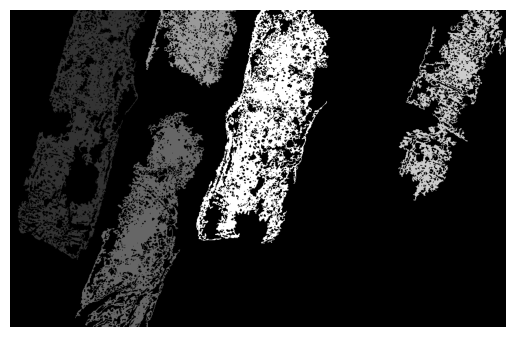

In [71]:
plt.imshow(segmented_image, cmap='grey')
plt.axis('off')

___

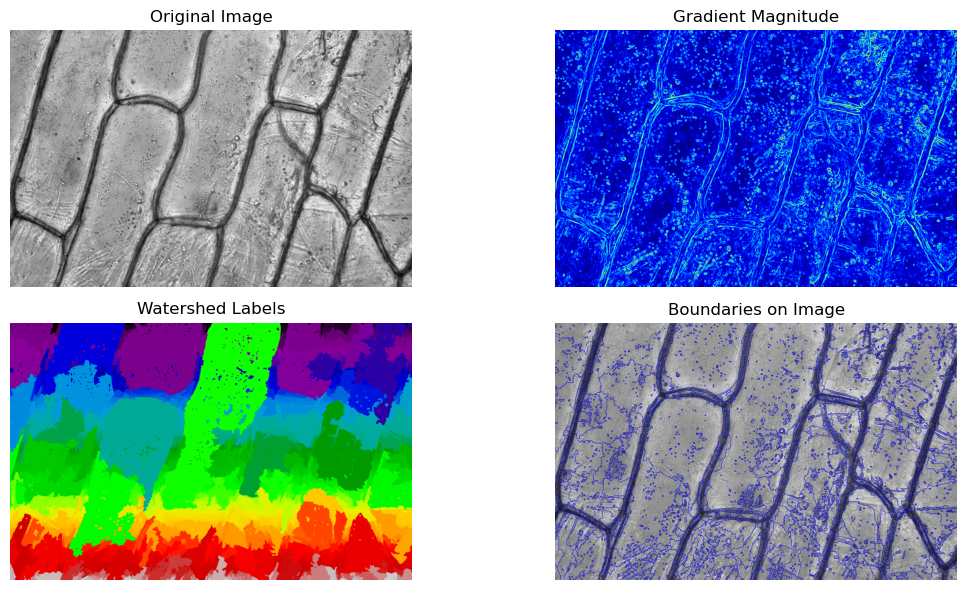

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# Load grayscale image
image = cv2.imread('images/q4/cells.png', cv2.IMREAD_GRAYSCALE)

# Compute gradient magnitude using Sobel filters
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
gradient_magnitude = (gradient_magnitude / gradient_magnitude.max() * 255).astype(np.uint8)

# Use distance transform to find seed points
ret, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
distance = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

# Find local maxima as watershed markers
coordinates = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
local_maxi = np.zeros_like(distance, dtype=bool)
local_maxi[tuple(coordinates.T)] = True

# Label markers
markers, _ = ndi.label(local_maxi)

# Apply watershed algorithm on the gradient image
labels = watershed(gradient_magnitude, markers)

# Overlay watershed boundaries on original image
boundaries = cv2.Canny(labels.astype(np.uint8), 0, 1)
overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
overlay[boundaries > 0] = [0, 0, 255]  

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Gradient Magnitude')
plt.imshow(gradient_magnitude, cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Watershed Labels')
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Boundaries on Image')
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()
